In [3]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from lib import *


## Single run of Klien

In [2]:
k = np.linspace(0,1,7)
a, b, c = Klein_simulation(0.3, 0.95, 500000, k)


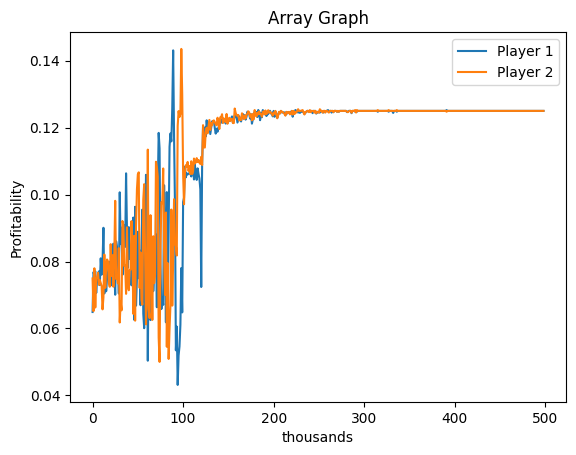

In [3]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

# joint profit maximizing

In [24]:
avg_prof= run_sim(100, np.linspace(0,1,7))

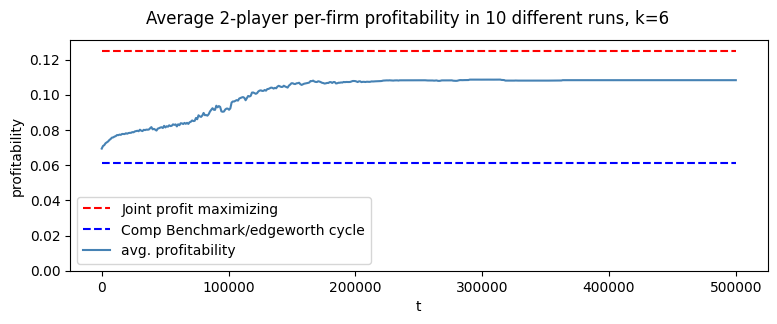

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [26]:
avg_prof[498]

0.10826236111111102

## Price cycles

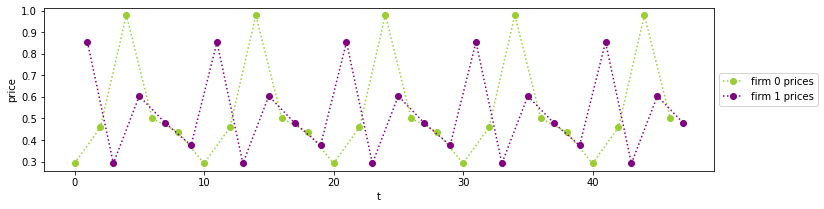

In [6]:
p, b, c = Klein_simulation(0.3, 0.95, 500000, np.linspace(0,1,49))
p1 = p[0,499950:500000]
p2 = p[1,499950:500000]

plt.figure(figsize=(12, 3))
p0s2d = p1[np.arange(0, p1.size, 2)][:-1]
p1s2d = p2[np.arange(1, p2.size, 2)][:-1]

plt.xlabel("t")
plt.ylabel("price")
plt.plot(range(0, 48, 2), p0s2d , label="firm 0 prices", marker="o", color="yellowgreen", linestyle="dotted")
plt.plot(range(1, 48, 2), p1s2d, label="firm 1 prices", marker="o", color="purple", linestyle="dotted")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Forced deviation

In [7]:
Monk, profits, avg_2pp1,avg2pp2,avg_profitabilities= run_simFD(100,np.linspace(0,1,7))

In [9]:
MAnkA = Monk[0,::2]
MAnkaB = Monk[1,::2]

### Average Price

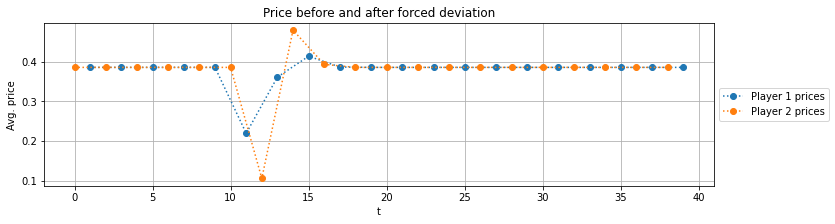

In [10]:
xvalues = range(len(MAnkA[199995:200015]))
#print(p2)
#print(new)
# Plot the array as a line graph
plt.figure(figsize=(12, 3))
plt.plot(range(1,len(xvalues)*2,2), MAnkA[199995:200015], marker="o", linestyle='dotted')
plt.plot(range(0,len(xvalues)*2,2), MAnkaB[199995:200015], marker="o", linestyle='dotted')
#plt.plot(xvalues, p2, marker="o", linestyle='dotted')

# Add labels and title
plt.grid()
plt.xlabel('t')
plt.ylabel('Avg. price')
plt.title('Price before and after forced deviation')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

### Average Two-Period Profit

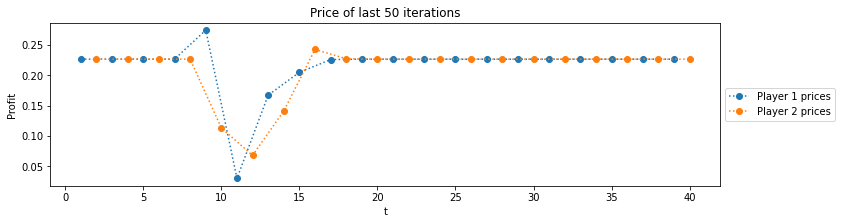

In [14]:
zoom1 = avg_profitabilities[0,199995:200015]
zoom2 = avg_profitabilities[1,199995:200015]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)


xvalues = range(len(zoom1))
plt.figure(figsize=(12, 3))
# Plot the array as a line graph
plt.plot(range(1,len(xvalues)*2,2), zoom1, marker="o", linestyle='dotted')
plt.plot(range(2,len(xvalues)*2+1,2), zoom2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Profit')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

In [12]:
done = True
while done:
    a, b, c, d = Klein_simulation_FD(0.3, 0.95, 500000, np.linspace(0,1,7))
    if abs(c[498] - d[498]) < 0.001 and abs(c[497] - d[497]) < 0.001 : 
        done = False

### Average market price

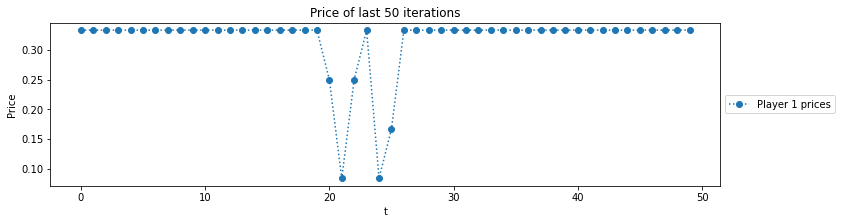

In [13]:
p1 = a[0,399980:400030]
p2 = a[1,399980:400030]

#p1 = p1[1::2]
#p2 = p2[::2]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)
#print(p1)
new=[]
for i in range(len(p1)):
    res=(p1[i]+p2[i])/2
    new.append(res)

xvalues = range(len(new))
plt.figure(figsize=(12, 3))
#print(p2)
#print(new)
# Plot the array as a line graph
plt.plot(xvalues, new, marker="o", linestyle='dotted')
#plt.plot(xvalues, p2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Price')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

# Testing klein v2

In [40]:
@njit
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, delta, p_table, Q_table, price_grid, s_next) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        delta: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    maxed_Q = max(Q_table[:, s_next_index])
    new_est = profit(p_table[i, t], p_table[j, t-2]) + delta * profit(p_table[i, t], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

    

In [41]:
@njit
def Klein_simulation2(alpha, delta, T, price_grid):
    """
    args:
        alpha: step-size parameter
        delta: discount factor
        T: learning duration
        price_grid: price_grid
    returns:
        p_table: 2x500.000 array, with all prices set by player 0 and 1
        avg_profs0: player 0 list of average profit for each 1000 period
        avg_profs1: player 1 list of average profit for each 1000 period
    """
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = np.random.choice(price_grid) #p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        p_table[i,t] = p_table[i,t-1]
        p_idx = np.where(price_grid == p_table[i,t])[0][0]
        s_next = p_table[j,t-1]
        #print(s_next)
        #s_next_idx = np.where(price_grid == s_next)[0][0]
        current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
        q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, delta, p_table, q1, price_grid, s_next)

        p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
        p_table[j, t] = p_table[j, t-1]

        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        
    return p_table, avg_profs1, avg_profs2


In [42]:
k = np.linspace(0,1,7)
a, b, c = Klein_simulation2(0.3, 0.95, 500000, k)


In [49]:
a[0,10:20]

array([0.5       , 0.5       , 0.83333333, 0.83333333, 0.33333333,
       0.33333333, 0.83333333, 0.83333333, 0.16666667, 0.16666667])

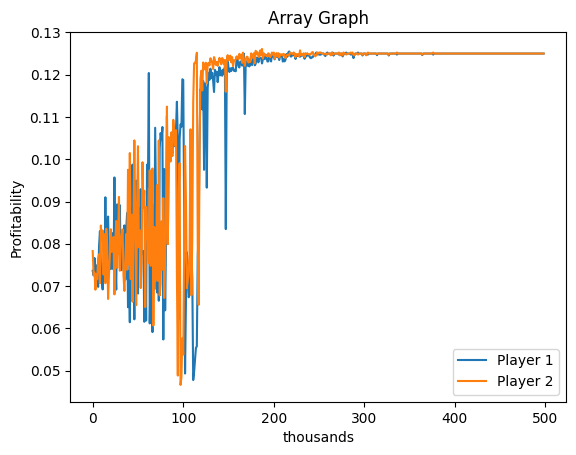

In [43]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [44]:
def run_sim(runs, k, method='klein'):
    
    num_calcs=int(500000/1000-1)
    summed_avg_profitabilities = np.zeros(num_calcs)

    for n in range(0, runs):
        p_table, avg_profs1, avg_profs2 = Klein_simulation2(0.3, 0.95, 500000, k)
        #print(avg_profs1)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, runs)
    return avg_avg_profitabilities

In [45]:
abe=run_sim(100, np.linspace(0,1,7))

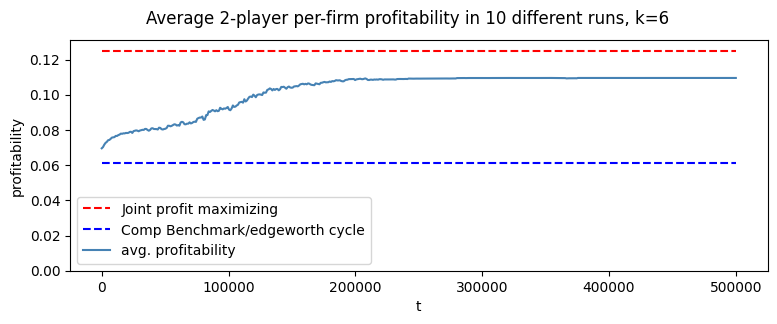

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, abe, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [47]:
print(abe[498])

0.10952597222222309
